# Combining ARIMA with Decomposition

We've already gone through the process of a simple ARIMA model. In this exercise we're going to build on that slightly by using a combination of an ARIMA model with the `seasonal decompose` tool you saw in the lecture. There are models we can use __specifically__ for dealing with seasonality, but we're going to go step by step here and manually pull apart this time series so we fully understand it and some of the issues we can have when working with TS data.

For this challenge we're going to be working with the daily CO2 ppm measurements, specifically, the daily CO2 measurements from the Mauna Loa Observatory 🌋

They have been taken since since 1958, and are a cornerstone of climate science. Perched at over 3,000 meters in Hawaii, the observatory is well-positioned to monitor global atmospheric carbon levels, largely free from local emissions. While the record is robust, __it does contain gaps due to occasional instrument issues or extreme weather__, which researchers must account for in their analyses to maintain the integrity of this critical dataset.  We'll be using a portion of data that has been taken __almost__ daily since 1974 - we will address the gaps in the data throughout the course of the notebook!

If you're curious about the climate work done by the lab, you can read more about it here: https://gml.noaa.gov/ccgg/about/co2_measurements.html

## Loading and exploring the data

In [234]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [235]:
df = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/05-Machine-Learning/09-Time-Series/co2_daily_mlo.csv")

In [236]:
df

,year,month,day,CO2 molfrac (ppm)
0,1974,5,17,333.38
1,1974,5,18,333.11
2,1974,5,19,333.46
3,1974,5,20,333.64
4,1974,5,21,333.50
...,...,...,...,...
15191,2023,10,19,419.44
15192,2023,10,20,419.53
15193,2023,10,21,418.90
15194,2023,10,23,419.09


We can see the data isn't formatted very nicely for us to work with, so let's solve that step first by using `pd.to_datetime()` (you can use the function on multiple columns at once 👀). Check the [docs](https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html) to find out more.

Once you've formatted it correctly, set it as your index.

In [237]:
df['date'] = pd.to_datetime(df.iloc[:,0:3])
df.set_index('date', inplace=True)
df.drop(columns=['year', 'month', 'day'], inplace=True)

Plot out your CO2 values and discuss with your partner what you see. Does it look like you have any gaps in your data? Are you __sure__? Check the top 50 values of your DataFrame

<Axes: xlabel='date'>

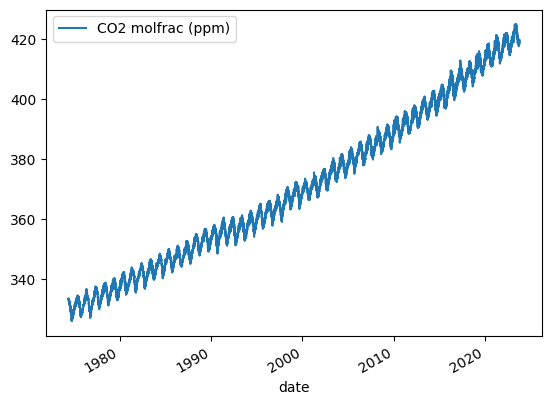

In [238]:
df.plot()

In [239]:
df.head(50)

,CO2 molfrac (ppm)
date,
1974-05-17,333.38
1974-05-18,333.11
1974-05-19,333.46
1974-05-20,333.64
1974-05-21,333.50
1974-05-22,333.21
1974-05-23,333.05
1974-05-26,333.32
1974-05-27,332.79


We're missing some dates 😱 Even though we don't have any obvious `NaN` values, there are missing dates from our index. This is something you need to be __really__ careful about with TS data.

Let's work out how many days we're missing. Subtracting your end date (the `max()` of your `index`) from your start date (the `min()` of your `index`)to see how many days __should__ between the two.

In [240]:
df.index[-1] - df.index[0]

Timedelta('18057 days 00:00:00')

How does this differ from the number of days we __actually__ have in our DataFrame? Save your answer to a variable `missing`

In [241]:
missing = 18057 - 15196

In [242]:
from nbresult import ChallengeResult

result = ChallengeResult('missing',
                         missing = missing)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_missing.py::TestMissing::test_missing PASSED                        [100%]

============================== 1 passed in 0.03s ===============================


💯 You can commit your code:

git add tests/missing.pickle

git commit -m 'Completed missing step'

git push origin master



In [243]:
!git add tests/missing.pickle

!git commit -m 'Completed missing step'

!git push origin master

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   arima_seasonal_intro.ipynb
	modified:   tests/baseline.pickle
	modified:   tests/fullpreds.pickle
	modified:   tests/monthly.pickle
	modified:   tests/preds.pickle

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date


Let's actually see where are missing values lie. Use `pd.date_range` to create the index we __should__ have. Then use the DataFrame's `.reindex()` function with this new date range to see where our null values actually are in our first 100 entries!

In [244]:
df = df.reindex(pd.date_range(start=df.index[0], end=df.index[-1]))

<Axes: >

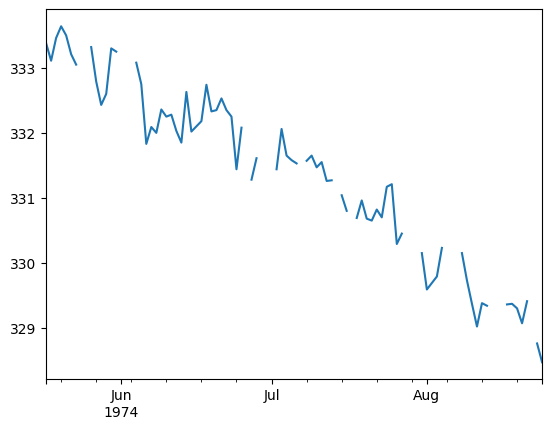

In [245]:
df["CO2 molfrac (ppm)"][:100].plot()

We simplest option here is to use the very useful `pd.interpolate("linear")` function to fill these in for us. Try running the cell below to see what it does:

<Axes: >

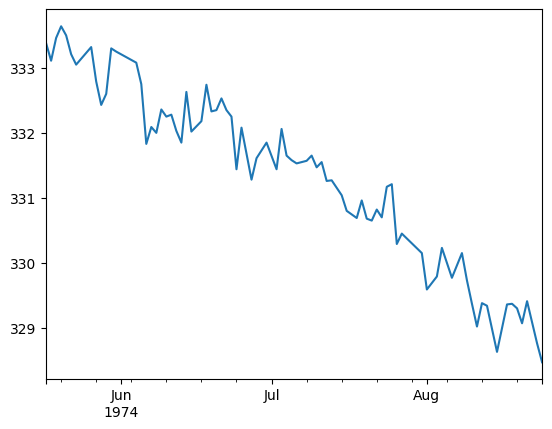

In [246]:
df["CO2 molfrac (ppm)"][:100].interpolate("linear").plot()

Interpolation uses a simple linear method to connect the dots for us 😊 Obviously this is making some assumptions that aren't perfectand we don't actually need to have daily samples - instead we'll `resample` our DataFrame on a monthly basis and try to model that. Try using the `.resample()` function to create a DataFrame with each month's average and name it `monthly`. See [docs](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) here.

In [247]:
monthly = df.resample('ME').mean()

If you __still__ have any remaining null values, you can use the `interpolate` to fill them in. Plot out your resampled data:

<Axes: >

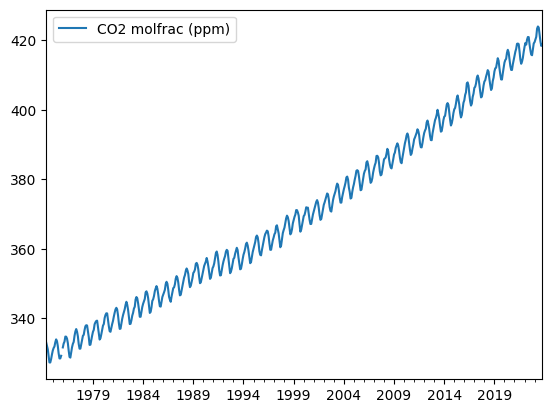

In [248]:
monthly.plot()

<Axes: >

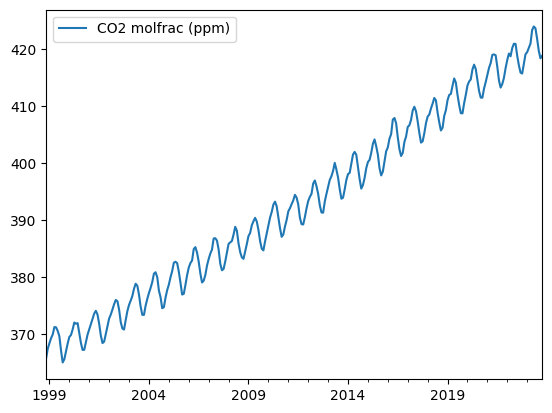

In [249]:
monthly[-300:].plot()

In [250]:
monthly["CO2 molfrac (ppm)"].iloc[0]

333.1569230769231

In [251]:
from nbresult import ChallengeResult

result = ChallengeResult('monthly',
                         monthly = monthly)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_monthly.py::TestMonthly::test_first_value PASSED                    [ 50%]
test_monthly.py::TestMonthly::test_missing PASSED                        [100%]

=============================== warnings summary ===============================
test_monthly.py::TestMonthly::test_first_value
  /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests/test_monthly.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
    self

In [252]:
# !git add tests/monthly.pickle

# !git commit -m 'Completed monthly step'

# !git push origin master

## Train test split

Next up we need to split into a train and test set (we'll do an 80:20 split). Be cautious when doing this - we need our sets to be __continuous__!

In [253]:
train = monthly[:round(monthly.shape[0] * 0.8)]
test = monthly[round(monthly.shape[0] * 0.8):]

Our data preparation is almost done. Before we start decomposing and modelling though, we should come up with a baseline to see how our model performs. 

The typical baselines we'd pick is just to guess the last available value to us. In our case, this is simply the final point in our `train` DataFrame.

In your `test` DataFrame, create a column called `naive_preds` and set it to be equal to our last available data point in `train`


In [254]:
test['naive_preds'] = train['CO2 molfrac (ppm)'].iloc[-1]

/tmp/ipykernel_129527/3106845001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_preds'] = train['CO2 molfrac (ppm)'].iloc[-1]


In [255]:
test.head()

,CO2 molfrac (ppm),naive_preds
2013-12-31,397.024000,395.360667
2014-01-31,398.043226,395.360667
2014-02-28,398.268889,395.360667
2014-03-31,399.895455,395.360667
2014-04-30,401.488889,395.360667


Once you have this, calculate the mean absolute error between the two columns and set this as your `baseline_mae`.

In [256]:
baseline_mae = np.mean(np.abs(test['CO2 molfrac (ppm)'] - test['naive_preds']))
baseline_mae

14.503777783267303

In [257]:
from nbresult import ChallengeResult

result = ChallengeResult('baseline',
                         test = test,
                         baseline_mae = baseline_mae)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 3 items

test_baseline.py::TestBaseline::test_baseline_mae PASSED                 [ 33%]
test_baseline.py::TestBaseline::test_first_value PASSED                  [ 66%]
test_baseline.py::TestBaseline::test_missing PASSED                      [100%]

=============================== warnings summary ===============================
test_baseline.py::TestBaseline::test_first_value
  /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests/test_baseline.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wi

In [258]:
# !git add tests/baseline.pickle

# !git commit -m 'Completed baseline step'

# !git push origin master

## Getting ready to model

With some Time Series models, we can simply throw our data at it and hope that it will decompose it, make it stationary for us and then model it for us (SARIMAX or TBATS are good examples of this), but we're going to go step by step instead. Since we're not relying on a model to remove seasonality and trend for us, we will take care of them ourselves.

Import the `seasonal_decompose` tool that you saw in the lecture and try both methods on your Time Series (both "multiplicative" and "additive"). 

In [259]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [260]:
train = train[["CO2 molfrac (ppm)"]].interpolate("linear")

In [261]:
train

,CO2 molfrac (ppm)
1974-05-31,333.156923
1974-06-30,332.170400
1974-07-31,331.110000
1974-08-31,329.105769
1974-09-30,327.303182
...,...
2013-07-31,397.451905
2013-08-31,395.393704
2013-09-30,393.726538
2013-10-31,393.904286


In [262]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_add = seasonal_decompose(train, model='additive')

In [263]:
# Additive Decomposition (y = Trend + Seasonal + Residuals)
result_mul = seasonal_decompose(train, model='multiplicative')

Plot the residuals (access the `.resid` attribute) from both and remember - we want the one that looks as __non-influenced__ by time as possible

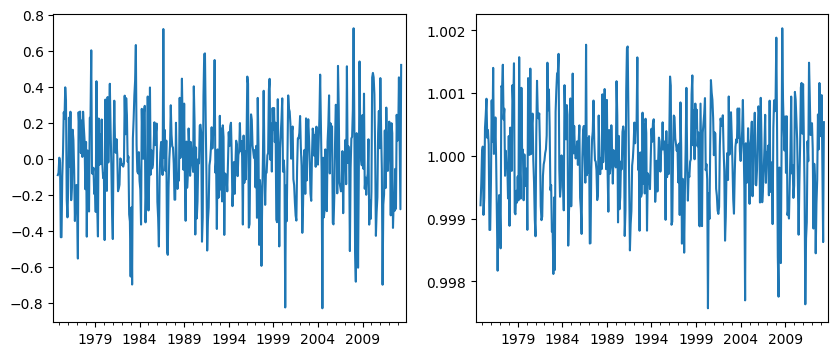

In [264]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
result_add.resid.plot(ax=ax1);
result_mul.resid.plot(ax=ax2);

Since both look reasonably stationary, we'll pick the multiplicative model.

Our strategy now is to take out the seasonal component of our time series. 

How can we do this? 🤔


First, create a column called `"seasonal_component"`in your `train` DataFrame that is filled with the `.seasonal` component of your time series. 

After you do this, create a separate, smaller DataFrame that only includes __one year__ of seasonal components (ie. the first 12 rows of your `seasonal components` column). This will be useful for us later on. Name it `seasonal_one_year` and make sure you have a `"month"` column equal to the corresponding `index.month` (e.g. you have have a row with the January seasonal component and a 1 next to it). 

<img src = "https://wagon-public-datasets.s3.amazonaws.com/data-science-images/05-ML/09-Time-Series/seasonal_component_one.png">

In [265]:
train['seasonal_component'] = result_mul.seasonal
train.head()

,CO2 molfrac (ppm),seasonal_component
1974-05-31,333.156923,1.008482
1974-06-30,332.170400,1.006564
1974-07-31,331.110000,1.001811
1974-08-31,329.105769,0.995762
1974-09-30,327.303182,0.990900


In [266]:
seasonal_one_year = train[['seasonal_component']].iloc[:12]
seasonal_one_year['month'] = seasonal_one_year.index.month
seasonal_one_year

,seasonal_component,month
1974-05-31,1.008482,5
1974-06-30,1.006564,6
1974-07-31,1.001811,7
1974-08-31,0.995762,8
1974-09-30,0.990900,9
1974-10-31,0.990801,10
1974-11-30,0.994131,11
1974-12-31,0.997567,12
1975-01-31,1.000244,1
1975-02-28,1.002097,2


Since this is from a multiplicative model, if we want to __remove__ this seasonal component, we'll need to __divide__ our original time series by these repeating (12-month cycle) values.

In [267]:
from nbresult import ChallengeResult

result = ChallengeResult('seasonal',
                         train = train,
                         seasonal = seasonal_one_year)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_seasonal.py::TestSeasonal::test_seasonal_column PASSED              [ 50%]
test_seasonal.py::TestSeasonal::test_seasonal_year_shape PASSED          [100%]

============================== 2 passed in 0.85s ===============================


💯 You can commit your code:

git add tests/seasonal.pickle

git commit -m 'Completed seasonal step'

git push origin master



In [268]:
# !git add tests/seasonal.pickle

# !git commit -m 'Completed seasonal step'

# !git push origin master

Create a new column named `"seasonal_stripped"` equal to the value of your original time series divided by the seasonal component.

In [269]:
train['seasonal_stripped'] = train['CO2 molfrac (ppm)'] / train['seasonal_component']
train.head()

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped
1974-05-31,333.156923,1.008482,330.354959
1974-06-30,332.170400,1.006564,330.004173
1974-07-31,331.110000,1.001811,330.511417
1974-08-31,329.105769,0.995762,330.506354
1974-09-30,327.303182,0.990900,330.308904


Plot this new column out:

<Axes: >

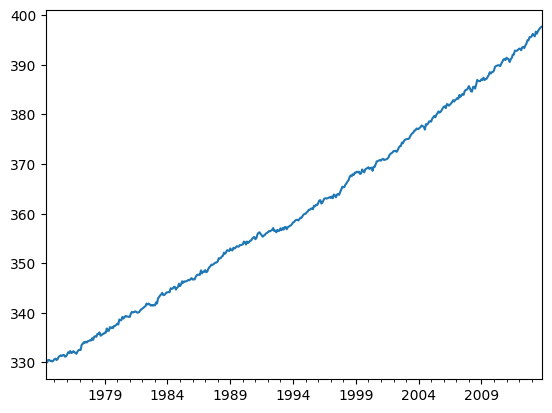

In [270]:
train['seasonal_stripped'].plot()

Does it look stationary yet? Discuss with your buddy for the day why or why not.

Our next task is to take this __deseasonalized__ time series and to make it stationary. Try using `.diff()` and see how it looks. Then try diffing one more time to see any changes. 

In [271]:
zero_diff = train['seasonal_stripped']
first_order_diff = train['seasonal_stripped'].diff().dropna()
second_order_diff = train['seasonal_stripped'].diff().diff().dropna()

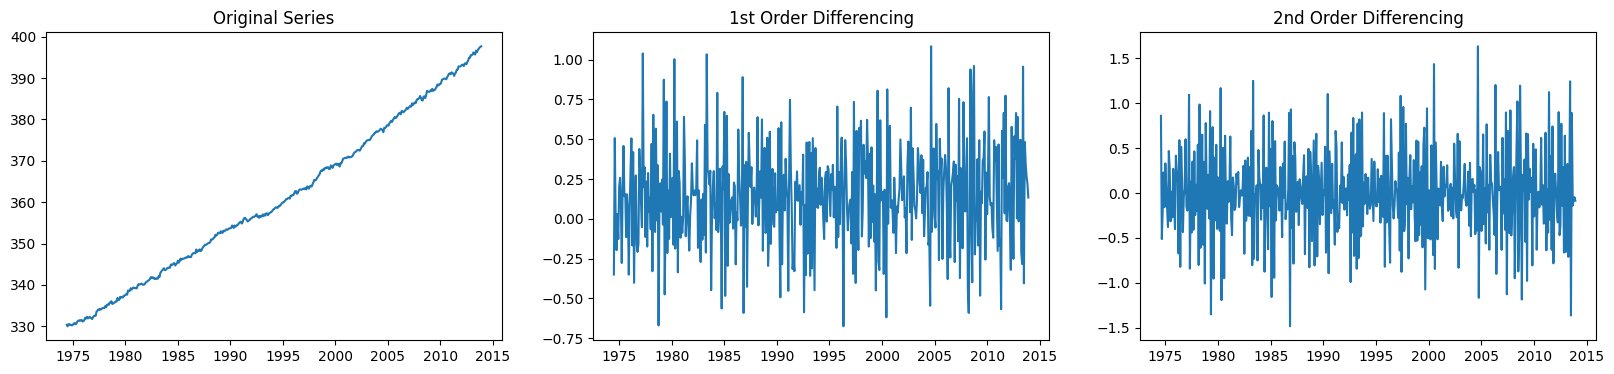

In [272]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')
ax3.plot(second_order_diff); ax3.set_title('2nd Order Differencing');

Both should look quite stationary visually, use the `adfuller` (Augmented Dicky-Fuller) test from the lecture to verify that each one is. 

N.B. When you `diff` you create null values in your DataFrame, you'll need to drop these to perform an ADF test.

In [273]:
from statsmodels.tsa.stattools import adfuller

In [274]:
# check with ADF Test for stationarity
print('p-value zero-diff: ', adfuller(zero_diff)[1])
print('p-value first-diff: ', adfuller(first_order_diff)[1])
print('p-value second-diff: ', adfuller(second_order_diff)[1])

p-value zero-diff:  1.0
p-value first-diff:  4.816418008792879e-06
p-value second-diff:  1.2453738770611307e-23


Both seem to be reasonably stationary, and it looks like there's no need to overdifference (though we can always try building a twice-diffed time series later). Let's go ahead and plot our `acf` and `pacf` plots (be sure to drop any `null` values - those will break your ACF and PACF calculators) 😔

In [275]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

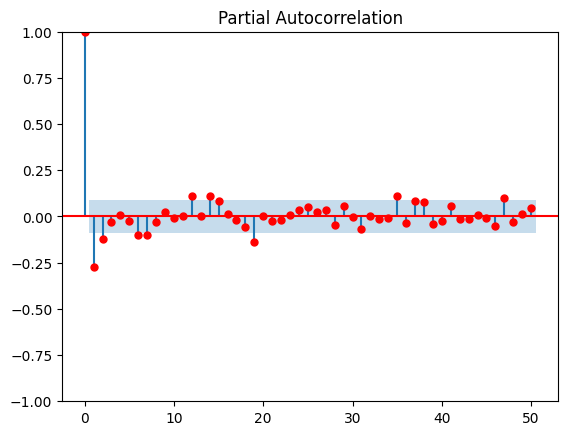

In [276]:
plot_pacf(first_order_diff, lags=50, c='r');

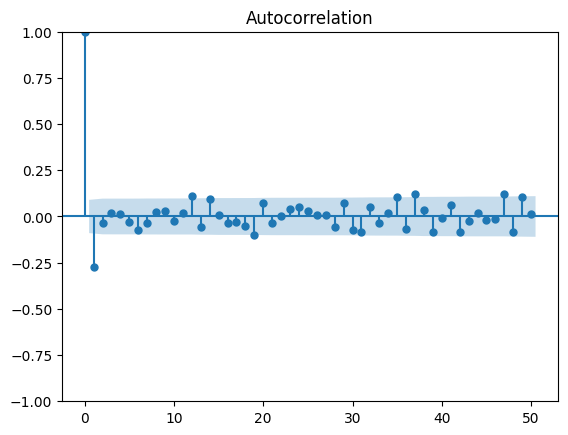

In [277]:
plot_acf(first_order_diff, lags=50);

Take the time to really talk through what these plots actually mean with your buddy. Which one corresponds to your `p` parameter and which corresponds to your `q` parameter?

Now build a simple ARIMA model with the appropriate order values for your `p` `d` and `q` values. Investigate its model summary.

In [278]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(zero_diff, order=(2, 1, 1))
arima = arima.fit()

arima.summary()

/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      seasonal_stripped   No. Observations:                  475
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -107.921
Date:                Thu, 15 May 2025   AIC                            223.842
Time:                        17:02:25   BIC                            240.487
Sample:                    05-31-1974   HQIC                           230.388
                         - 11-30-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7212      0.043     16.934      0.000       0.638       0.805
ar.L2          0.2787      0.043      6.540      0.000       0.195       0.362
ma.L1         -0.9922      0.010    -94.764      0.000      -1.013      -0.972
sigma2         0.0917      0.006     16.359      0.000       0.081       0.103
===================================================================================
Ljung-Box (L1) (Q):                   0.82   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.37   Prob(JB):                         0.31
Heteroskedasticity (H):               1.14   Skew:                             0.02
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

What do you note about the summary? What are the most important features here?

It looks like we can trust our coefficients and we have an AIC of ~223. But was it the best model? Trying using the `auto_arima` function to grid search different models and see which has the best AIC

In [279]:
from pmdarima.arima import auto_arima

In [280]:
smodel = auto_arima(train['seasonal_stripped'], test='adf', trace=True,
                       start_p=0, max_p=3, start_d=0, max_d=1, start_q=0, max_q=3,
                       suppress_warnings=True)

/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=252.307, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=216.874, Time=0.19 sec


/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=209.862, Time=2.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=338.365, Time=0.10 sec


/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=211.246, Time=1.40 sec


/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=211.280, Time=0.54 sec


/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=213.283, Time=1.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=339.127, Time=0.09 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 6.079 seconds


/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Save your best AIC score to `best_AIC`

In [281]:
smodel

ARIMA(order=(0, 1, 1), scoring_args={}, suppress_warnings=True)

In [282]:
best_AIC = smodel.aic()

In [283]:
from nbresult import ChallengeResult

result = ChallengeResult('score',
                         aic_score = best_AIC)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 1 item

test_score.py::TestScore::test_AIC_score PASSED                          [100%]

============================== 1 passed in 0.27s ===============================


💯 You can commit your code:

git add tests/score.pickle

git commit -m 'Completed score step'

git push origin master



In [284]:
!git add tests/score.pickle

!git commit -m 'Completed score step'

!git push origin master

On branch master
Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   arima_seasonal_intro.ipynb
	modified:   tests/baseline.pickle
	modified:   tests/fullpreds.pickle
	modified:   tests/monthly.pickle
	modified:   tests/preds.pickle

no changes added to commit (use "git add" and/or "git commit -a")
Everything up-to-date


Often times, it can be hard to predict which model with fit best on our data so it is usually a good idea to grid-search and compare your models' AIC scores 🧐 Here, it looks like a __(0,1,1)__ model gets a better AIC score (so the MA components of our original model probably weren't improving our model likelihood that much!)

### Making predictions (get ready for some Pandas work!)

Now that we have our best model, we'd like to generate some predictions and - crucially - some confidence intervals. Use your model to predict for the length of your test set and ensure that you also return those intervals (use `return_conf_int = True`). Create a `preds_df` DataFrame with columns for `preds`, `upper` and `lower` bounds.

In [285]:
arima = ARIMA(train['seasonal_stripped'], order=(0, 1, 1), trend='t')
arima = arima.fit()

In [286]:
## Forecast
# Forecast values
forecast = arima.forecast(len(test), alpha=0.05)  # 95% confidence

# Forecast values and confidence intervals
forecast_results = arima.get_forecast(len(test), alpha=0.05)
forecast = forecast_results.predicted_mean
confidence_int = forecast_results.conf_int().values

/home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/lib/python3.12/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['alpha']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [287]:
preds_df = pd.DataFrame(forecast)

In [288]:
preds_df['lower'] = confidence_int[:,0]
preds_df['upper'] = confidence_int[:,1]

In [289]:
preds_df.rename(columns={"predicted_mean": "preds"}, inplace=True)

In [290]:
from nbresult import ChallengeResult

result = ChallengeResult('preds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_preds.py::TestPreds::test_df_values PASSED                          [ 50%]
test_preds.py::TestPreds::test_preds_cols PASSED                         [100%]

=============================== warnings summary ===============================
test_preds.py::TestPreds::test_df_values
  /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests/test_preds.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
    self.assert

In [291]:
# !git add tests/preds.pickle

# !git commit -m 'Completed preds step'

# !git push origin master

Now plot them, out and see how they look compared alongside your `train` data

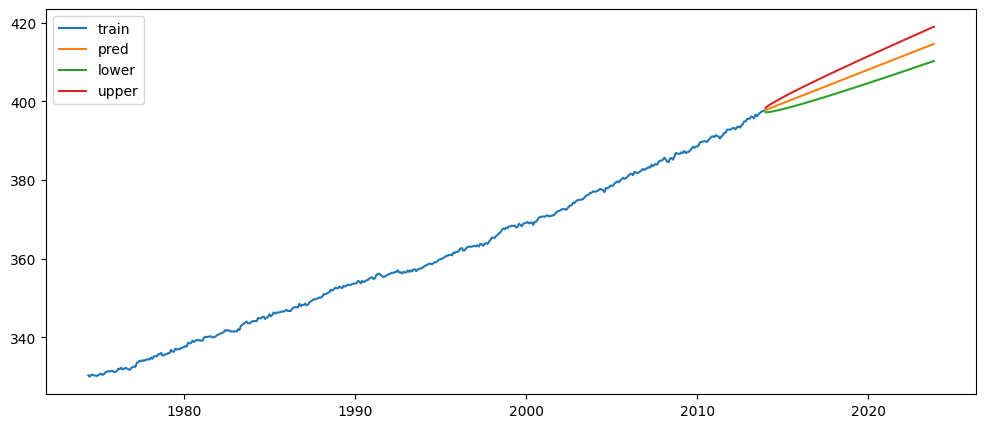

In [292]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train['seasonal_stripped'], label='train')
axs.plot(preds_df['preds'], label='pred')
axs.plot(preds_df['lower'], label='lower')
axs.plot(preds_df['upper'], label='upper')
plt.legend()

Something looks a bit wrong doesn't it? We're looking at three straight lines coming out of something that clearly had seasonality. To account for this, we need to re-incorporate the seasonality component that we extracted earlier!

Create a `month` column in your `preds_df` DataFrame and populate it with the month component of the index. 

In [293]:
preds_df['month'] = preds_df.index.month

In [294]:
preds_df

,preds,lower,upper,month
2013-12-31,397.824562,397.236601,398.412522,12
2014-01-31,397.966878,397.257365,398.676392,1
2014-02-28,398.109195,397.296101,398.922289,2
2014-03-31,398.251512,397.346617,399.156407,3
2014-04-30,398.393829,397.405625,399.382033,4
...,...,...,...,...
2023-06-30,414.048681,409.767920,418.329443,6
2023-07-31,414.190998,409.891855,418.490141,7
2023-08-31,414.333315,410.015868,418.650761,8
2023-09-30,414.475632,410.139959,418.811304,9


Now we can take our `seasonal_one_year` DataFrame that we made earlier and simply merge it onto our `preds_df`!

In [295]:
preds_df = preds_df.merge(seasonal_one_year, on='month')

In [296]:
preds_df

,preds,lower,upper,month,seasonal_component
0,397.824562,397.236601,398.412522,12,0.997567
1,397.966878,397.257365,398.676392,1,1.000244
2,398.109195,397.296101,398.922289,2,1.002097
3,398.251512,397.346617,399.156407,3,1.004264
4,398.393829,397.405625,399.382033,4,1.007375
...,...,...,...,...,...
114,414.048681,409.767920,418.329443,6,1.006564
115,414.190998,409.891855,418.490141,7,1.001811
116,414.333315,410.015868,418.650761,8,0.995762
117,414.475632,410.139959,418.811304,9,0.990900


Now you can create your `full_preds`, `upper_conf` and `lower_conf` (create them as new columns in the `preds_df` DataFrame) by multiplying out your `preds`, `upper` __and__ `lower` columns with the seasonal component that we now have in our `preds_df` DataFrame.

In [297]:
preds_df['full_preds'] = preds_df['preds'] * preds_df['seasonal_component']
preds_df['upper_conf'] = preds_df['upper'] * preds_df['seasonal_component']
preds_df['lower_conf'] = preds_df['lower'] * preds_df['seasonal_component']

Finally, to make plotting easier for us, set the index of your `preds_df` to be the same as the index of your `test` DataFrame (since they have the same length this should be quite easy for us!)

In [298]:
preds_df.index = test.index

In [299]:
from nbresult import ChallengeResult

result = ChallengeResult('fullpreds',
                         preds_df = preds_df)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/tanguy/.pyenv/versions/3.12.9/envs/lewagon/bin/python
cachedir: .pytest_cache
rootdir: /home/tanguy/code/Tanguyrhd/05-ML/09-Time-Series/data-arima-101/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_fullpreds.py::TestFullpreds::test_columns PASSED                    [ 50%]
test_fullpreds.py::TestFullpreds::test_index PASSED                      [100%]

============================== 2 passed in 0.98s ===============================


💯 You can commit your code:

git add tests/fullpreds.pickle

git commit -m 'Completed fullpreds step'

git push origin master



In [300]:
# !git add tests/fullpreds.pickle

# !git commit -m 'Completed fullpreds step'

# !git push origin master

Now plot everything out - the end of your train (e.g. the last 100 values, your full predictions, upper and lower confidence bounds and the true values from your `preds_df` DataFrame __and__ your baseline!

In [301]:
train

,CO2 molfrac (ppm),seasonal_component,seasonal_stripped
1974-05-31,333.156923,1.008482,330.354959
1974-06-30,332.170400,1.006564,330.004173
1974-07-31,331.110000,1.001811,330.511417
1974-08-31,329.105769,0.995762,330.506354
1974-09-30,327.303182,0.990900,330.308904
...,...,...,...
2013-07-31,397.451905,1.001811,396.733388
2013-08-31,395.393704,0.995762,397.076392
2013-09-30,393.726538,0.990900,397.342246
2013-10-31,393.904286,0.990801,397.561262


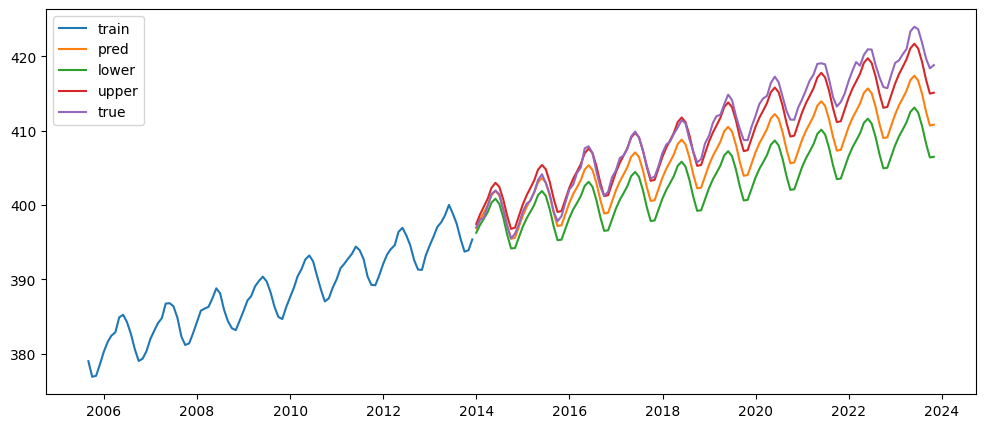

In [302]:
fig, axs = plt.subplots(1, 1, figsize=(12, 5))
axs.plot(train['CO2 molfrac (ppm)'].iloc[-100:], label='train')
axs.plot(preds_df['full_preds'], label='pred')
axs.plot(preds_df['lower_conf'], label='lower')
axs.plot(preds_df['upper_conf'], label='upper')
axs.plot(test['CO2 molfrac (ppm)'], label='true')
plt.legend()

Our predictions look pretty good! We can see that the true values are slightly higher than what we predicted but remains well within the bounds of our confidence intervals for a full 10 years out from when we started making our predictions.

Why did our values dip below the true values? Run the cell below to decompose the test data and take a look at the trend component 👀


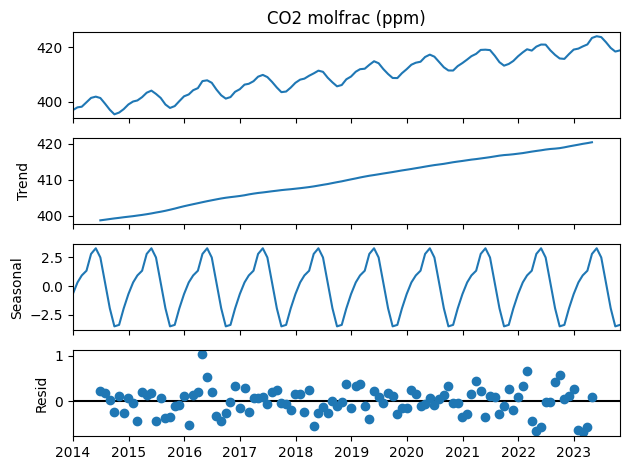

In [303]:
seasonal_decompose(test["CO2 molfrac (ppm)"]).plot();

It looks like in 2016-2018 there was a __slight rise__ in all of our values before the regular (slightly shallower) trend took over again. This is a great example of something occuring in our test dataset that we simply cannot predict. We don't know why there was a surge in CO2 readings - and we couldn't predict for it.

❗ When we model with Time Series, we __cannot magically predict the future__. What we're trying to do is accurately capture and then extend the patterns of the past. 

- Often times, your raw predictions (without a seasonal component) will look like a fairly boring straight line 🙄 (as our current initial ones did) but this is what we'd expect
- Some of the most value that we get out when doing Time Series analysis lies in being able to __quantify__ our trends, seasonal components and our confidence intervals so we can make well-informed decisions ✅

Finally, let's quickly quantify how much better our model was than our baseline. Calculate the mean absolute error between your `preds` (with their seasonal component) and the true values. See if your `model_mae` is lower than the original `baseline_mae`. 

In [304]:
model_mae = (test["CO2 molfrac (ppm)"] - preds_df["full_preds"]).mean()

In [305]:
print(model_mae, baseline_mae)

3.624302047851477 14.503777783267303


Our final MAE should be __much__ better than our original baseline. Great work 🥳 In another challenge, we'll explore how we can use Facebook Prophet to quickly make powerful predictions without the need for decomposition.